In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import preprocessing

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
device

device(type='cuda', index=0)

In [3]:
#based on https://towardsdatascience.com/build-a-simple-neural-network-using-pytorch-38c55158028d
n_input, n_hidden, n_hidden2, n_out, batch_size, learning_rate, momentum, num_workers = 9, 15, 10, 2, 300, 0.001, 0.99, 0

In [4]:
full_pd = pd.read_csv('237k.csv')
full_tensor = torch.tensor(full_pd.to_numpy()).float()
full_pd.shape

(237484, 11)

In [5]:
scaler = preprocessing.MinMaxScaler()

In [6]:
full_scaled = torch.tensor(scaler.fit_transform(full_tensor)).float()
full_scaled[:10, :]

tensor([[0.0000e+00, 0.0000e+00, 1.4286e-01, 1.4286e-01, 3.1193e-01, 4.0891e-01,
         7.9886e-01, 7.3915e-01, 3.0244e-03, 5.5611e-02, 5.8032e-01],
        [4.2857e-01, 0.0000e+00, 2.8571e-01, 5.7143e-01, 3.7063e-01, 4.2484e-01,
         8.6386e-01, 7.3438e-01, 4.4560e-04, 1.0000e+00, 5.4318e-03],
        [2.8571e-01, 8.5714e-01, 0.0000e+00, 8.5714e-01, 6.6664e-02, 6.9349e-01,
         5.0336e-01, 6.1156e-01, 4.1963e-05, 1.0000e+00, 5.3588e-03],
        [1.4286e-01, 7.1429e-01, 7.1429e-01, 1.4286e-01, 5.7649e-02, 9.4421e-01,
         5.6026e-01, 7.1128e-01, 3.8886e-04, 1.0000e+00, 5.4436e-03],
        [2.8571e-01, 0.0000e+00, 5.7143e-01, 5.7143e-01, 3.2106e-01, 3.5409e-01,
         5.8771e-01, 6.2953e-01, 1.2502e-03, 6.7290e-01, 1.2079e-01],
        [4.2857e-01, 1.4286e-01, 4.2857e-01, 4.2857e-01, 9.0662e-01, 2.9580e-01,
         1.0988e-01, 4.7156e-01, 1.6752e-02, 8.0884e-01, 1.0302e-01],
        [7.1429e-01, 1.0000e+00, 0.0000e+00, 8.5714e-01, 4.1767e-01, 8.2794e-01,
         6.98

In [7]:
train_n = {"data": full_scaled[:80000, :9].to(device), "target": full_scaled[:80000, 9:].to(device)}
test_n = {"data": full_scaled[:-10000, :9].to(device), "target": full_scaled[:-10000, 9:].to(device)}

test_n["data"].requires_grad=False
test_n["target"].requires_grad=False

train, validate, test = torch.utils.data.random_split(full_scaled, [200000, 27484, 10000])
#train, validate, test = torch.utils.data.random_split(full_scaled, [80000, 14765, 10000])
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

In [8]:
model = nn.Sequential(nn.Linear(9, 300),
                      nn.ReLU(),
                      nn.Linear(300, 2),
                      nn.Sigmoid())
# model = nn.Sequential(nn.Linear(9, 15),
#                       nn.ReLU(),
#                       nn.Linear(15, 10),
#                       nn.ReLU(),
#                       nn.Linear(10, 2),
#                       nn.Sigmoid())
model.to(device)
print(model)

Sequential(
  (0): Linear(in_features=9, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=2, bias=True)
  (3): Sigmoid()
)


In [9]:
loss_function = nn.HuberLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
#torch.multiprocessing.set_start_method('spawn')
import time

tim = time.time()

losses = []
test_losses = []
for i in range(15):
    for j, item in enumerate(train_loader):
        train_x, train_y = item[:, :9], item[:, 9:]
        
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        
        pred_y = model(train_x)
        loss = loss_function(pred_y, train_y)
        losses.append(loss.item())

        model.zero_grad()
        loss.backward()

        optimizer.step()
        
    test_pred_y = model(test_n["data"])
    test_loss = loss_function(test_pred_y, test_n["target"])
    test_losses.append(test_loss)
    
print(time.time() - tim)

25.26473569869995


In [11]:
#losses = []
#test_losses = []
#for i in range(100):
#    for j in range(0, train_n["data"].shape[0], batch_size):
#        train_x, train_y = train_n["data"][j:j+batch_size], train_n["target"][j:j+batch_size]
#        
#        pred_y = model(train_x)
#        loss = loss_function(pred_y, train_y)
#        losses.append(loss.item())
#
#        model.zero_grad()
#        loss.backward()
#
#        optimizer.step()
#
#    test_pred_y = model(test_n["data"])
#    test_loss = loss_function(test_pred_y, test_n["target"])
#    test_losses.append(test_loss)

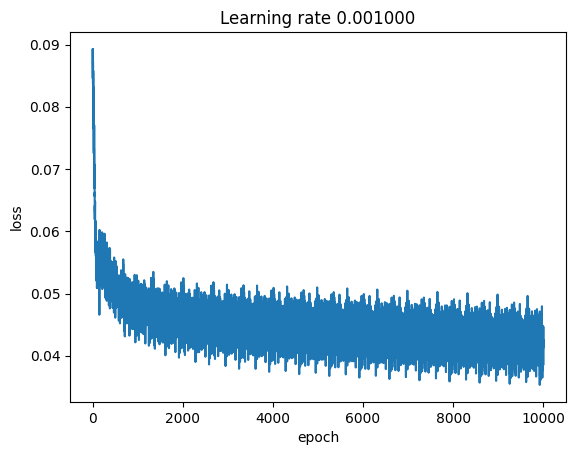

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [13]:
test_losses

[tensor(0.0492, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0469, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0458, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0452, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0448, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0445, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0442, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0439, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0436, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0434, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0431, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0429, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0426, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0424, device='cuda:0', grad_fn=<HuberLossBackward0>),
 tensor(0.0421, device='cuda:0', grad_fn=<HuberLossBackward0>)]

In [14]:
#                                      bandwidth ↓
model(torch.tensor([1., 1., 1., 1., 1., 1., 1., 100., 1.]))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)

In [ ]:
#                                      bandwidth ↓
model(torch.tensor([1., 1., 1., 1., 1., 1., 1., 1000., 1.]))

In [ ]:
full_scaled[230000:230005, :9]

In [ ]:
inf_scaled = model(full_scaled[230000:230005, :9])
inf_scaled

In [ ]:
remerged = torch.cat((full_scaled[230000:230005, :9], inf_scaled), 1)
remerged

In [ ]:
torch.tensor(scaler.inverse_transform(remerged.detach().numpy())[:, 9:])

In [ ]:
full_tensor[230000:230005, 9:]